In [6]:
import numpy as np
import cv2 as cv
import glob
from matplotlib import pyplot as plt

In [7]:
import os
print(os.getcwd())

/Users/ericharvey/git/seedo/test/camera_test/dual_cam


In [8]:
data = np.load('stereo_params.npz')

In [9]:
mtxL  = data["mtxL"]
distL = data["distL"]
mtxR  = data["mtxR"]
distR = data["distR"]
R     = data["R"]
T     = data["T"]


print (T)



[[-0.1154862 ]
 [ 0.00111277]
 [-0.00030204]]


In [10]:
l_img_path = 'left_001a.jpg'
r_img_path = 'right_001a.jpg'
r_img = cv.imread(l_img_path,cv.IMREAD_GRAYSCALE)
l_img = cv.imread(r_img_path, cv.IMREAD_GRAYSCALE)

(1536, 864)

Rectification ROIs:
ROI Left : (55, 71, 1406, 771)
ROI Right: (83, 24, 1393, 772)


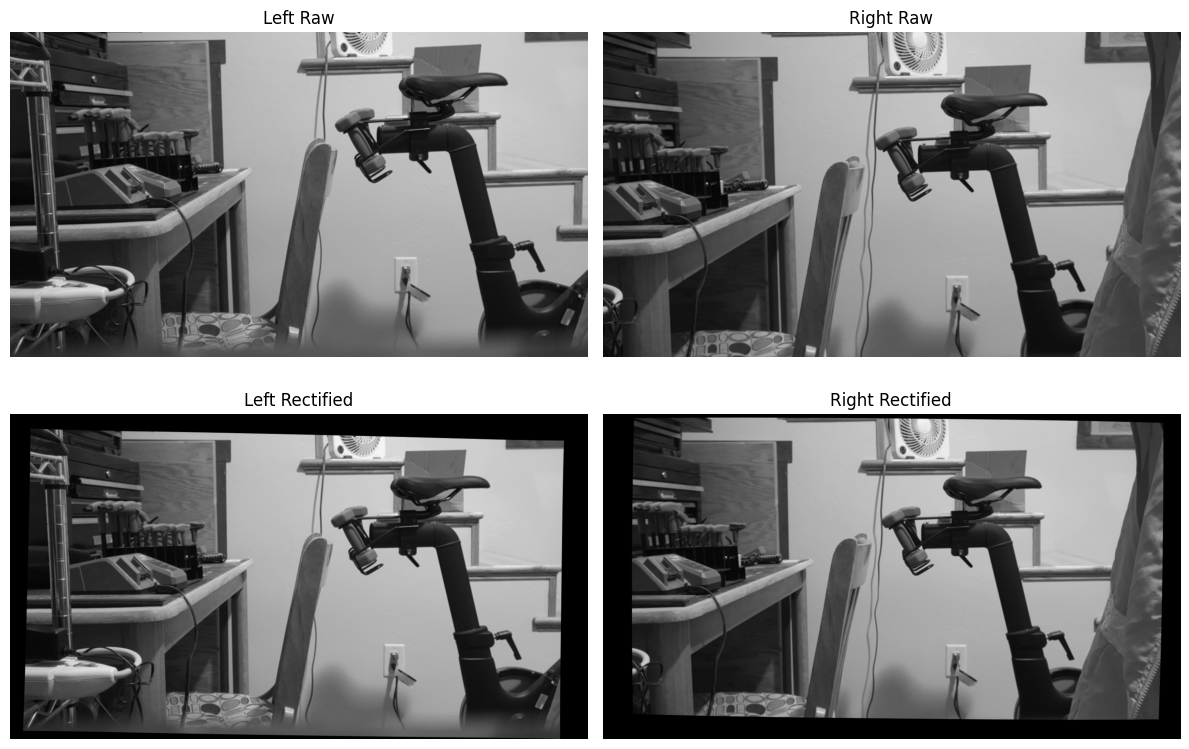

In [73]:
h, w = l_img.shape[:2]
img_size = (w,h)
print(img_size)

R1, R2, P1, P2, Q, roi1, roi2 = cv.stereoRectify(
    mtxL, distL, mtxR, distR,
    img_size,
    R, T,
    flags=cv.CALIB_ZERO_DISPARITY,
    alpha=1,  # 0=zoom crop, 1=full view
    newImageSize=img_size       # <-- prevents black frames

)

print("\nRectification ROIs:")
print("ROI Left :", roi1)
print("ROI Right:", roi2)

mapLx, mapLy = cv.initUndistortRectifyMap(
    mtxL, distL, R1, P1, img_size, cv.CV_32FC1)

mapRx, mapRy = cv.initUndistortRectifyMap(
    mtxR, distR, R2, P2, img_size, cv.CV_32FC1)

# --- Remap images ---
l_rect = cv.remap(l_img, mapLx, mapLy, cv.INTER_LINEAR)
r_rect = cv.remap(r_img, mapRx, mapRy, cv.INTER_LINEAR)

# ========== Display Result ==========
plt.figure(figsize=(12,8))
plt.subplot(2,2,1); plt.title("Left Raw"); plt.imshow(l_img, cmap='gray'); plt.axis('off')
plt.subplot(2,2,2); plt.title("Right Raw"); plt.imshow(r_img, cmap='gray'); plt.axis('off')
plt.subplot(2,2,3); plt.title("Left Rectified"); plt.imshow(l_rect, cmap='gray'); plt.axis('off')
plt.subplot(2,2,4); plt.title("Right Rectified"); plt.imshow(r_rect, cmap='gray'); plt.axis('off')
plt.tight_layout(); plt.show()

In [74]:
print("R=\n",R)
print("T=\n",T)
print("Baseline magnitude (m):", np.linalg.norm(T))

R=
 [[ 0.99985114 -0.00899409 -0.01472411]
 [ 0.0094258   0.9995198   0.02951816]
 [ 0.01445155 -0.02965256  0.99945579]]
T=
 [[-0.1154862 ]
 [ 0.00111277]
 [-0.00030204]]
Baseline magnitude (m): 0.11549195591459023


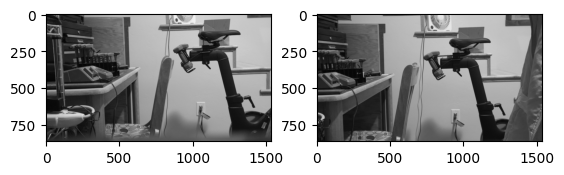

In [75]:
plt.figure()
plt.subplot(221)
plt.imshow(l_img, 'grey')
plt.subplot(222)
plt.imshow(r_img, 'grey')


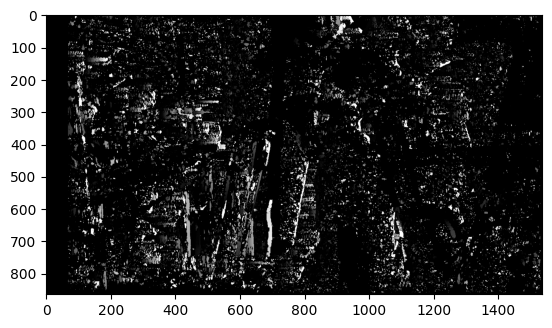

In [88]:
def computerDepthMapBM(r_img, l_img):
  nDispFactor = 4
  stereo = cv.StereoBM_create(numDisparities=16*nDispFactor, blockSize=11)
  disparity = stereo.compute(r_img, l_img)
  plt.imshow(disparity,'grey')
  plt.show()
  return disparity

dis = computerDepthMapBM(r_img,l_img)


In [58]:
dis[:][500]

array([-16, -16, -16, ..., -16, -16, -16], shape=(1536,), dtype=int16)

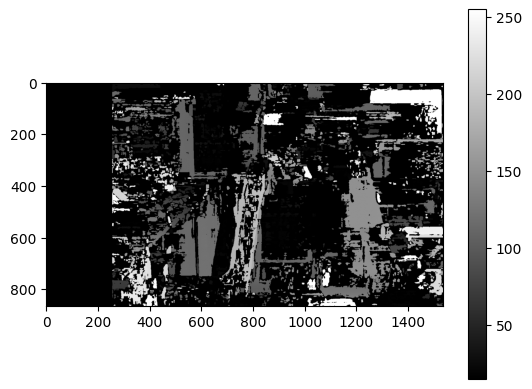

In [120]:
def computeDepthMapSGBM(l_img, r_img):
  window_size=10
  min_disp=16
  nDispFactor = 16
  num_disp = 16 * nDispFactor - min_disp

  stero = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=window_size,
    P1=8*3*window_size**2,
    P2=32*3*window_size**2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=18,
    speckleRange=2,
    preFilterCap=63,
    mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
  )

  disparity = stero.compute(r_img,l_img).astype(np.float32)/16

  plt.imshow(disparity, 'grey')
  plt.colorbar()
  plt.show()

computeDepthMapSGBM(r_img, l_img)